In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
import seaborn as sns
from category_encoders import OneHotEncoder
from glob import glob
import plotly.express as px
from sklearn.utils.validation import check_is_fitted
from ipywidgets import interact, Dropdown, IntSlider, FloatSlider
from IPython.display import display
import ipywidgets as widgets
import pickle


Wrangle function for the data preparation:
Subset data to have apartments in ("Distrito Federal") costing less that $100000
Rm outliers- trim area by bottom and top 10% quantiles
Split the lat-lon column and placewithparentnames to have the neighborhood
Drop columns with > 50% null values
Drop low and high cardinality columns
Drop Columns that would cause target leakage
Drop Columns that would create multicollunearity issues

In [2]:
def wrangle(path):
    df = pd.read_csv(path)
    
    city = df['place_with_parent_names'].str.contains("Distrito Federal")
    property= df["property_type"].str.contains("apartment")
    price = df["price_aprox_usd"] < 100000
    df = df[city  & property & price]
    
    #trim area by top and bottom 10% quantile low=48, high =91
    low,high = df["surface_covered_in_m2"].quantile([0.1,0.9])
    area = df["surface_covered_in_m2"].between(low,high)
    df = df[area]
    
    df[["lat","lon"]] = df["lat-lon"].str.split(',', expand = True).astype(float)
    df.drop(columns = "lat-lon", inplace = True)
    df["neighbourhood"] = df["place_with_parent_names"].str.split('|', expand = True)[1]
    df.drop(columns = "place_with_parent_names", inplace = True)
    
    nulls = df.isnull().sum()
    clmns = nulls[nulls>555].keys() # ['surface_total_in_m2', 'price_usd_per_m2', 'floor', 'rooms', 'expenses']
    df.drop(clmns, axis = "columns", inplace = True)
    #high cardinality: several number of unique value > half properati_url
    df.drop(columns ="properati_url", inplace = True)
    #low cardinality columns
    df.drop(columns = ["operation","property_type","currency"], inplace = True)
    
    #Leaky features price price_aprox_local_currency price_per_m2
    df.drop(columns = ["price_aprox_local_currency","price_per_m2","price"], inplace = True)  
      
    return df

In [3]:
df1 = wrangle(r"C:\Users\Administrator\Desktop\Data Expert\Data Analytics\Projects\World Quant\Housing in Buenos Aires\data\mexico-city-real-estate-1.csv")
print(df1.shape)
df1.head(7)

(1101, 5)


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighbourhood
11,94022.66,57.0,23.634501,-102.552788,Benito Juárez
20,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,68228.99,80.0,19.357820,-99.149406,Benito Juárez
22,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
26,94140.20,50.0,19.354219,-99.126244,Coyoacán
32,76395.40,90.0,19.400785,-99.147419,Benito Juárez
43,40103.52,65.0,19.366632,-99.197900,Álvaro Obregón


In [22]:
#check for columns with >50% null
null = df1.isnull().sum()
clmns = null[null>550].keys() # ['surface_total_in_m2', 'price_usd_per_m2', 'floor', 'rooms', 'expenses']
# nulls =null*100/len(df1)
# clmns = nulls[nulls>50].keys()
clmns


Index(['surface_total_in_m2', 'price_usd_per_m2', 'floor', 'rooms',
       'expenses'],
      dtype='object')

In [29]:
df1.isnull().sum()

price_aprox_usd             0
surface_total_in_m2      1000
surface_covered_in_m2       0
price_usd_per_m2         1031
floor                    1101
rooms                    1095
expenses                 1101
lat                        60
lon                        60
neighbourhood               0
dtype: int64

Cardinality: number / frequency of unque values in a column
High cardinality: several number of unique value > half properati_url 
low cardinality :low records of unique values <10 operation property_type currency

In [ ]:
#check cardinality for cartegorical columns #eclude number
categorical = df1.select_dtypes(include = "object")
categorical.nunique()
#df1.nunique()

operation           1
property_type       1
currency            1
properati_url    1101
neighbourhood      14
dtype: int64

Leakage training data has infor about the target that will not be available when the model is used for prediction. Perfomance is high and looks accurate on training set but poor and inaccurate in production
Target Leakage: features include data that will not be available during prediction
Train-test Contamination: occurs when validation data is included in the model prediction. Frequently occure when data split is not done before feature engineering / preprocessing

In [6]:
#Leaky features price price_aprox_local_currency price_per_m2
df1.columns

Index(['price', 'price_aprox_local_currency', 'price_aprox_usd',
       'surface_covered_in_m2', 'price_per_m2', 'neighbourhood'],
      dtype='object')

In [4]:
#Pattern match files using glob
files = glob(r"C:\Users\Administrator\Desktop\Data Expert\Data Analytics\Projects\World Quant\Housing in Buenos Aires\data\mexico-city-real-estate*")
files

['C:\\Users\\Administrator\\Desktop\\Data Expert\\Data Analytics\\Projects\\World Quant\\Housing in Buenos Aires\\data\\mexico-city-real-estate-1.csv',
 'C:\\Users\\Administrator\\Desktop\\Data Expert\\Data Analytics\\Projects\\World Quant\\Housing in Buenos Aires\\data\\mexico-city-real-estate-2.csv',
 'C:\\Users\\Administrator\\Desktop\\Data Expert\\Data Analytics\\Projects\\World Quant\\Housing in Buenos Aires\\data\\mexico-city-real-estate-3.csv',
 'C:\\Users\\Administrator\\Desktop\\Data Expert\\Data Analytics\\Projects\\World Quant\\Housing in Buenos Aires\\data\\mexico-city-real-estate-4.csv',
 'C:\\Users\\Administrator\\Desktop\\Data Expert\\Data Analytics\\Projects\\World Quant\\Housing in Buenos Aires\\data\\mexico-city-real-estate-5.csv']

In [7]:
# for file in files:
#     [wrangle(file)]
# len(files)
# files[0]
#List Comprehension to wrangle all files
datafiles = [wrangle(file) for file in files]
len(datafiles)
datafiles[1].shape
#concat all dataframes
df = pd.concat(datafiles)
print(df.shape)
df.head(5)


(5473, 5)


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighbourhood
11,94022.66,57.0,23.634501,-102.552788,Benito Juárez
20,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,68228.99,80.0,19.357820,-99.149406,Benito Juárez
22,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
26,94140.20,50.0,19.354219,-99.126244,Coyoacán


In [5]:
#combine the list comprehension and concat
df = pd.concat([wrangle(file) for file in files])
print(df.shape)
df.head(3)

(5473, 5)


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighbourhood
11,94022.66,57.0,23.634501,-102.552788,Benito Juárez
20,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,68228.99,80.0,19.357820,-99.149406,Benito Juárez


In [ ]:
def clean_data(df):
    #combine the above steps into a function
    files = glob(r"C:\Users\Administrator\Desktop\Data Expert\Data Analytics\Projects\World Quant\Housing in Buenos Aires\data\mexico-city-real-estate*")
    df = pd.concat([wrangle(file) for file in files])
    return df
print(df.shape)
df.head


(5473, 5)


In [9]:
#save cleaned data to csv
df.to_csv(r"C:\Users\Administrator\Desktop\Data Expert\Data Analytics\Projects\World Quant\Housing in Buenos Aires\data\mexico-cleaned-data.csv", index = False)
clean_data = pd.read_csv(r"C:\Users\Administrator\Desktop\Data Expert\Data Analytics\Projects\World Quant\Housing in Buenos Aires\data\mexico-cleaned-data.csv")
clean_data.shape
clean_data.head(13)

,price_aprox_usd,surface_covered_in_m2,lat,lon,neighbourhood
0,94022.66,57.0,23.634501,-102.552788,Benito Juárez
1,70880.12,56.0,19.402413,-99.095391,Iztacalco
2,68228.99,80.0,19.357820,-99.149406,Benito Juárez
3,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
4,94140.20,50.0,19.354219,-99.126244,Coyoacán
5,76395.40,90.0,19.400785,-99.147419,Benito Juárez
6,40103.52,65.0,19.366632,-99.197900,Álvaro Obregón
7,68070.93,80.0,19.400731,-99.125466,Iztacalco
8,39409.48,61.0,19.337163,-99.080899,Iztapalapa
9,44794.13,55.0,19.435666,-99.149730,Cuauhtémoc


Text(0.5, 1.0, 'Distribution of Apartment Prices in Mexico City')

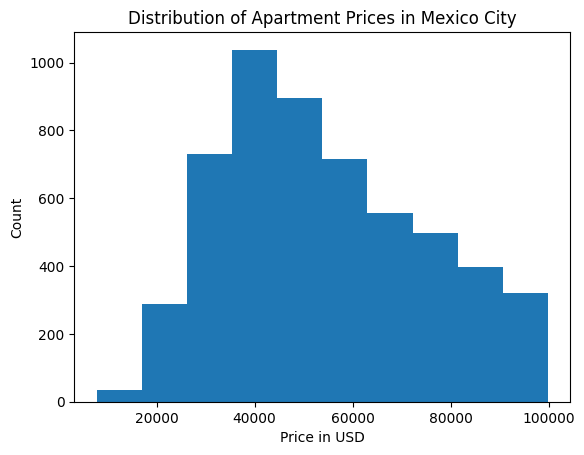

In [55]:
#show distribution of apartment prices
plt.hist(df["price_aprox_usd"], bins = 10)
plt.xlabel("Price in USD")
plt.ylabel("Count")
plt.title("Distribution of Apartment Prices in Mexico City")

Text(0.5, 1.0, 'Price vs Size')

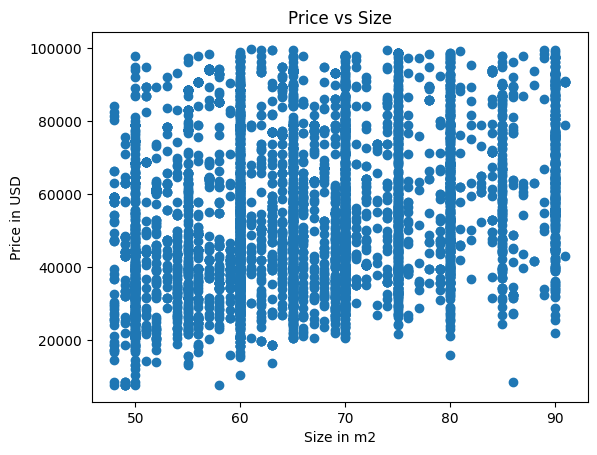

In [56]:
#show the relationship between apartment price and size
plt.scatter(x =df["surface_covered_in_m2"], y = df["price_aprox_usd"])
plt.xlabel("Size in m2")
plt.ylabel("Price in USD")
plt.title("Price vs Size")

In [62]:
#mapbox scatter plot
fig= px.scatter_mapbox(
    df,
    lat = "lat",
    lon = "lon",
    color = "price_aprox_usd",
    mapbox_style = "carto-positron",
    zoom = 13,
)
fig.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18964\1183194522.py:2: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



In [7]:
#Create Feature matrices and target vector
features = ["surface_covered_in_m2","lat","lon","neighbourhood"]
X_train = df[features]
y_train = df["price_aprox_usd"]

In [8]:
#create baseline MAE
y_mean = y_train.mean()
y_predbaseline = [y_mean] * len(y_train)
baseline_mean = mean_absolute_error(y_train, y_predbaseline)
print(round(y_mean,2))
print(round(baseline_mean, 2))

54246.53
17239.94


In [9]:
#create a pipeline that contains OneHotEncoder and SimpleImputer transformer and Ridge predictor Model
model = make_pipeline(
    OneHotEncoder(use_cat_names = True),
    SimpleImputer(),
    Ridge()
)
model.named_steps
#train the model
model.fit(X_train, y_train)
#make predictions
y_pred = model.predict(X_train)
y_pred[:3]

array([74307.13482649, 49999.34109049, 70485.08913983])

In [ ]:
#check if model is fitted
check_is_fitted(model)
#MAE
mean_absolute_error(y_train, y_pred)


14943.165824063904

Generalization: using model to make predictions of data other than training data

In [11]:
#evaluate the model
testdata = pd.read_csv(r"C:\Users\Administrator\Desktop\Data Expert\Data Analytics\Projects\World Quant\Housing in Buenos Aires\data\mexico-city-test-features.csv")
testdata = testdata.rename(columns ={"borough":"neighbourhood"})
testdata


,surface_covered_in_m2,lat,lon,neighbourhood
0,60,19.493185,-99.205755,Azcapotzalco
1,55,19.307247,-99.166700,Coyoacán
2,50,19.363469,-99.010141,Iztapalapa
3,60,19.474655,-99.189277,Azcapotzalco
4,74,19.394628,-99.143842,Benito Juárez
...,...,...,...,...
1036,70,19.490331,-99.207579,Azcapotzalco
1037,70,19.446852,-99.154461,Cuauhtémoc
1038,74,19.383251,-99.105499,Iztacalco
1039,70,19.339707,-99.131065,Coyoacán


In [12]:
y_pred_test= pd.Series(model.predict(testdata))
y_pred_test.head(3)

0    53538.366480
1    53171.988369
2    34263.884179
dtype: float64

In [13]:
#wrap model in a function
def model_prediction(area, lat, lon, neighbourhood):
    data ={
            "surface_covered_in_m2":[area],
            "lat":[lat],
            "lon":[lon],
            "neighbourhood":[neighbourhood]
        }
    df = pd.DataFrame(data)
    predictions = model.predict(df)
    return f"Predicted apartment price: ${predictions}"
    

In [14]:
model_prediction(100,19.493185,-99.205755,"Azcapotzalco")

'Predicted apartment price: $[65204.5327153]'

In [ ]:
interact(
    model_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighbourhood=Dropdown(options=sorted(X_train["neighbourhood"].unique()),
                           value=X_train["neighborhood"].mode()[0],
                           ),
);

In [15]:
#save the model to a file
with open("pricemodel.pkl", "wb") as f:
    pickle.dump(model, f)